In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import glob
import os
import sys
import miepython
import numpy as np
import dask
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import matplotlib.pyplot as plt
from re import split
from pytmatrix import tmatrix, tmatrix_aux, refractive
from pytmatrix.radar import radar_xsect
from pytmatrix.scatter import sca_xsect
from labellines import labelLine, labelLines
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']


/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
def _scatterer(d, ar, wlg, m, angle=180.0, rt=tmatrix.Scatterer.RADIUS_MAXIMUM):
    """
    Function that computes the scatterer object using pytmatrix package
    :param d: diameter in mm
    :param ar:  axis ratio
    :param wlg: wavelength in mm
    :param rt: maximum radius in mm
    :return: list of scatterers objects
    """
    return tmatrix.Scatterer(radius=d / 2., wavelength=wlg, m=m, axis_ratio=1.0 / ar,
                             phi=angle, radius_type=rt, ndgs=10)


def get_phase(x):
    return x.get_Z()[0, 0]


def phase_dask(d, wl="Ku", temp=0, m=None, _dask=False):
    if wl == "Ku":
        wlg = tmatrix_aux.wl_Ku
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_Ku]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ku]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ku]
    elif wl == "Ka":
        wlg = tmatrix_aux.wl_Ka
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_Ka]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ka]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ka]
    elif wl == "W":
        wlg = tmatrix_aux.wl_W
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_W]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_W]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_W]
    else:
        raise Exception('wl {} not valid. Please use Ka, Ku, or W'.format(wl))
    
    if dask == True:
        phase = []
        for i in d:
            scat = [dask.delayed(_scatterer)(i, 1, wlg, m, j) for j in np.arange(0, 180, 1)]
            phase.append([dask.delayed(get_phase)(k) for k in scat])
        return np.array(dask.compute(*phase, scheduler="processes"))
    else:
        return np.array([[_scatterer(i, 1, wlg, m, j).get_Z()[0, 0] for j in np.arange(0, 180, 1)] for i in d])
    
    

def size_parm(d, wl):
    if wl == "Ku":
        wlg = tmatrix_aux.wl_Ku
    elif wl == "Ka":
        wlg = tmatrix_aux.wl_Ka
    elif wl == "W":
        wlg = tmatrix_aux.wl_W
    return 2 * np.pi * (d / 2) / wlg


def scatt_eff_dask(d, wl="Ku", temp=0, m=None):
    if wl == "Ku":
        wlg = tmatrix_aux.wl_Ku
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_Ku]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ku]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ku]
    elif wl == "Ka":
        wlg = tmatrix_aux.wl_Ka
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_Ka]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ka]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_Ka]
    elif wl == "W":
        wlg = tmatrix_aux.wl_W
        if m is None:
            if temp == 0:
                m = refractive.m_w_0C[tmatrix_aux.wl_W]
            elif temp == 10:
                m = refractive.m_w_10C[tmatrix_aux.wl_W]
            else:
                m = refractive.m_w_10C[tmatrix_aux.wl_W]
    else:
        raise Exception('wl {} not valid. Please use Ka, Ku, or W'.format(wl))
    x = size_parm(d=d, wl=wl)
    sigma = []
    for i in d:
        scat = dask.delayed(_scatterer)(i, 1, wlg, m)
        sig = dask.delayed(sca_xsect)(scat)
        sigma.append(sig)
    sigma_ = np.array(dask.compute(*sigma, scheduler="processes"))
    qs = sigma_ / (np.pi * (d / 2) ** 2)
    return qs, x, m

def get_radius(wl, x):
    """
    Returns the radious for a size parameter and a given wavelenght
    """
    if wl == "Ku":
        wlg = tmatrix_aux.wl_Ku
    elif wl == "Ka":
        wlg = tmatrix_aux.wl_Ka
    elif wl == "W":
        wlg = tmatrix_aux.wl_W
    return wlg * x / (2 * np.pi )

In [3]:
cluster = SLURMCluster(queue="seseml",
                       memory='50GB',
                       cores=40,
                       processes=1,
                       walltime='24:00:00',
#                        scheduler_options={
#                            'host': '172.22.179.3:7225', 
#                            'dashboard_address': ':7799'
#                        }
                      )

cluster.scale(jobs=2)
cluster

In [4]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.22.178.84:33781,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Using PyTmatrix
### Scattering efficiency

In [5]:
d_ku = np.linspace(1, 50, 300)

In [6]:
%%time
qs_ku_dask_C0, x_ku, m_ku0 = scatt_eff_dask(d_ku, wl="Ku", m=complex(1.33, 0))
qs_ku_C1, x_ku, m_ku1 = scatt_eff_dask(d_ku, wl="Ku", m=complex(1.33, 0.1))
qs_ka_C2, x_ka, m_ku2 = scatt_eff_dask(d_ku, wl="Ku", m=complex(1.33, 1))
qs_ka_C3, x_ka, m_ku3 = scatt_eff_dask(d_ku, wl="Ku", m=complex(1.33, 0.01))

CPU times: user 5.15 s, sys: 1.13 s, total: 6.28 s
Wall time: 58.8 s


(0.1, 20)

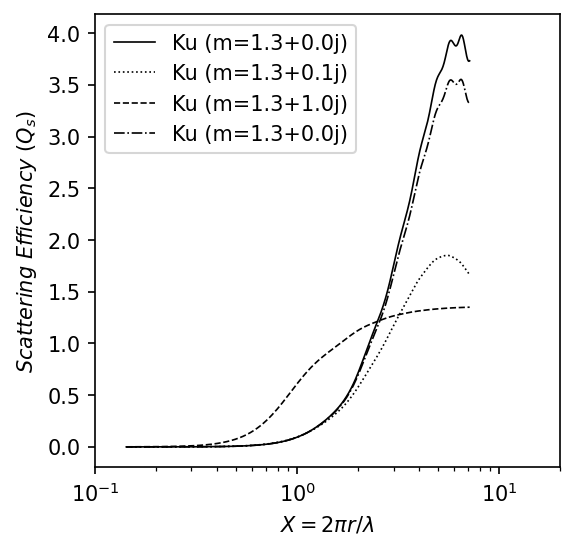

In [7]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.plot(x_ku, qs_ku_dask_C0, label=f'Ku (m={m_ku0:.1f})', c="k", lw=0.8)
ax.plot(x_ku, qs_ku_C1, label=f'Ku (m={m_ku1:.1f})', c="k", lw=0.8, ls=':')
ax.plot(x_ka, qs_ka_C2, label=f'Ku (m={m_ku2:.1f})', c="k", lw=0.8, ls='--')
ax.plot(x_ka, qs_ka_C3, label=f'Ku (m={m_ku3:.1f})', c="k", lw=0.8, ls='-.')

ax.set_xscale('log')
ax.set_ylabel(r'$Scattering \  Efficiency \ (Q_s)$')
ax.set_xlabel(r'$X = 2\pi r / \lambda$')
# ax.text(2.5, 0.75, f'm(Ku)={m_ku}, m(Ka)={m_ka}', fontsize=8)
ax.legend()
ax.set_xscale('log')
ax.set_xlim(0.1, 20)

In [8]:
%%time
d_ku_1 = np.linspace(1, 50, 300)
qs_ku_dask, x_ku_1, m_ku = scatt_eff_dask(d_ku_1, wl="Ku", m=None)
qs_ka_dask, x_ku_2, m_ka = scatt_eff_dask(d_ku_1, wl="Ka", m=None)

CPU times: user 17.7 s, sys: 1.12 s, total: 18.8 s
Wall time: 4min 44s


(0.1, 20)

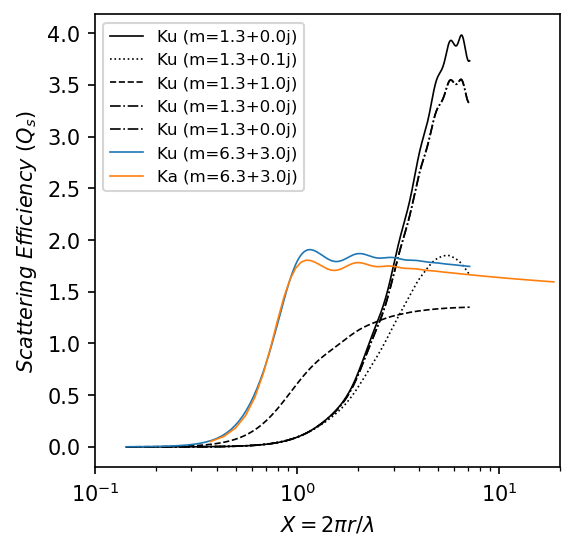

In [9]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.plot(x_ku, qs_ku_dask_C0, label=f'Ku (m={m_ku0:.1f})', c="k", lw=0.8)
ax.plot(x_ku, qs_ku_C1, label=f'Ku (m={m_ku1:.1f})', c="k", lw=0.8, ls=':')
ax.plot(x_ka, qs_ka_C2, label=f'Ku (m={m_ku2:.1f})', c="k", lw=0.8, ls='--')
ax.plot(x_ka, qs_ka_C3, label=f'Ku (m={m_ku3:.1f})', c="k", lw=0.8, ls='-.')
ax.plot(x_ka, qs_ka_C3, label=f'Ku (m={m_ku3:.1f})', c="k", lw=0.8, ls='-.')
ax.plot(x_ku_1, qs_ku_dask, label=f'Ku (m={m_ku:.1f})', c="C0", lw=0.8)
ax.plot(x_ku_2, qs_ka_dask, label=f'Ka (m={m_ku:.1f})', c="C1", lw=0.8)
ax.set_xscale('log')
ax.set_ylabel(r'$Scattering \  Efficiency \ (Q_s)$')
ax.set_xlabel(r'$X = 2\pi r / \lambda$')
ax.legend(fontsize=8)
ax.set_xscale('log')
ax.set_xlim(0.1, 20)

### Scattering phase function

In [10]:
%%time
x = np.array([1, 3, 10, 30])
d = get_radius(wl="Ku", x=x) * 2 
phase_ku = phase_dask(d, wl="Ku", m=complex(1.33), _dask=False)


CPU times: user 1min 5s, sys: 361 ms, total: 1min 5s
Wall time: 1min 5s


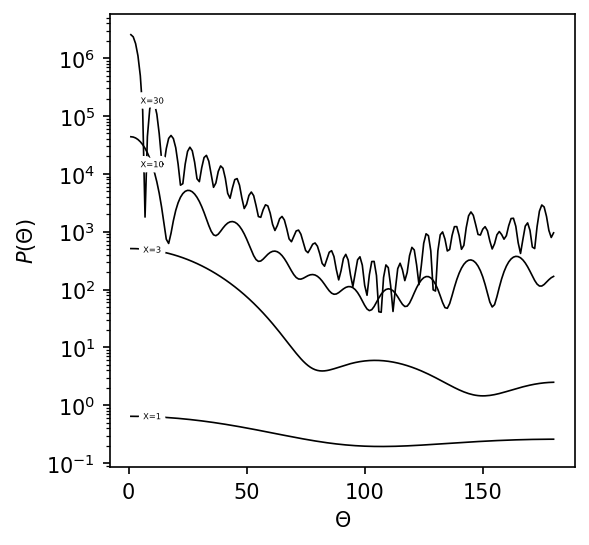

In [11]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
for i in range(phase_ku.shape[0]):
    ax.plot(np.arange(1, 181, 1), phase_ku[i, :], c="k", lw=0.8, label=f'X={x[i]}')
ax.set_ylabel(r'$P(\Theta)$')
ax.set_xlabel(r'$\Theta$')
ax.set_yscale('log')
labelLines(fig.gca().get_lines(), color='k', fontsize=4, align=False, xvals=(10, 10))
plt.show()

# Using MiePython

### Scattering Efficiency

In [21]:
x = np.linspace(0.1, 100, 3000)

m = [1.3 - 0.0j, 1.3 - 0.01j, 1.3 - 0.1j, 1.3 - 1j, refractive.m_w_0C[tmatrix_aux.wl_Ku], 
     refractive.m_w_0C[tmatrix_aux.wl_Ka]]
qext_1, qsca_1, qback_1, g_1 = miepython.mie(m[0], x)
qext_2, qsca_2, qback_2, g_2 = miepython.mie(m[1], x)
qext_3, qsca_3, qback_3, g_3 = miepython.mie(m[2], x)
qext_4, qsca_4, qback_4, g_4 = miepython.mie(m[3], x)
qext_5, qsca_5, qback_5, g_5 = miepython.mie(m[4], x)
qext_6, qsca_6, qback_6, g_6 = miepython.mie(m[5], x)

Text(0.5, 0, '$X = 2\\pi r / \\lambda$')

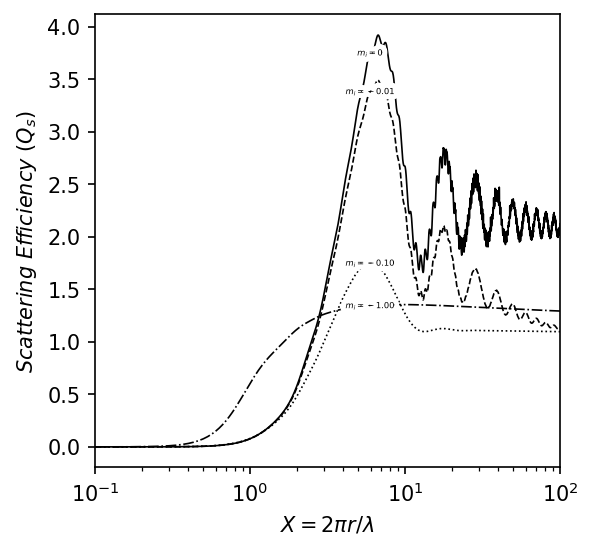

In [22]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.plot(x, qsca_1, c="k", lw=0.8, label=f'$m_i={m[0].imag:.0f}$')
ax.plot(x, qsca_2, c="k", lw=0.8, ls='--', label=f'$m_i={m[1].imag:.2f}$')
ax.plot(x, qsca_3, c="k", lw=0.8, ls=':', label=f'$m_i={m[2].imag:.2f}$')
ax.plot(x, qsca_4, c="k", lw=0.8, ls='-.', label=f'$m_i={m[3].imag:.2f}$')
ax.set_xscale('log')
ax.set_xlim(0.1, 100)
# ax.legend(fontsize=7)
_ = labelLines(fig.gca().get_lines(), color='k', fontsize=4, align=False, xvals=(6, 6))
ax.set_ylabel(r'$Scattering \  Efficiency \ (Q_s)$')
ax.set_xlabel(r'$X = 2\pi r / \lambda$')

### Scattering efficienciy for Ka and Ku wavelenghts (0 °C)

Text(0.5, 0, '$X = 2\\pi r / \\lambda$')

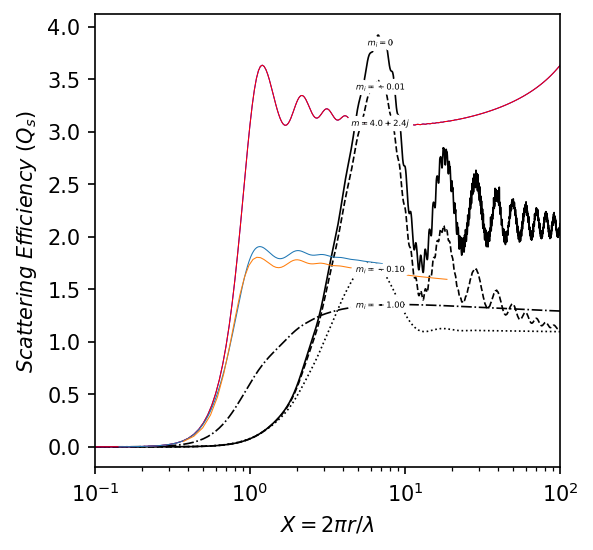

In [25]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.plot(x, qsca_1, c="k", lw=0.8, label=f'$m_i={m[0].imag:.0f}$')
ax.plot(x, qsca_2, c="k", lw=0.8, ls='--', label=f'$m_i={m[1].imag:.2f}$')
ax.plot(x, qsca_3, c="k", lw=0.8, ls=':', label=f'$m_i={m[2].imag:.2f}$')
ax.plot(x, qsca_4, c="k", lw=0.8, ls='-.', label=f'$m_i={m[3].imag:.2f}$')
ax.plot(x, qsca_5, c="blue", lw=0.5, label=f'$m={m[4]:.1f}$')
ax.plot(x, qsca_5, c="red", lw=0.5, label=f'$m={m[5]:.1f}$')
ax.plot(x_ku_1, qs_ku_dask, c="C0", lw=0.5, )
ax.plot(x_ku_2, qs_ka_dask, c="C1", lw=0.5, )
lines = fig.gca().get_lines()
l1 = lines[:-2]

ax.set_xscale('log')
ax.set_xlim(0.1, 100)
_ = labelLines(l1, color='k', fontsize=4, align=False, xvals=(7, 7))
# labelLine(lines[-2], 0.7, fontsize=4, 
#          label=f"{lines[-4].get_label()}")
# labelLine(lines[-1], 0.9, fontsize=4, 
#          label=f"{lines[-1].get_label()}")
ax.set_ylabel(r'$Scattering \  Efficiency \ (Q_s)$')
ax.set_xlabel(r'$X = 2\pi r / \lambda$')

Text(0.5, 0, '$X = 2\\pi r / \\lambda$')

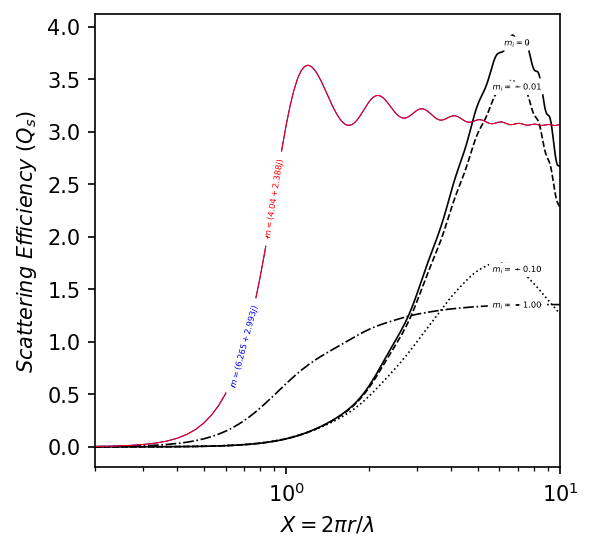

In [15]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.plot(x, qsca_1, c="k", lw=0.8, label=f'$m_i={m[0].imag:.0f}$')
ax.plot(x, qsca_2, c="k", lw=0.8, ls='--', label=f'$m_i={m[1].imag:.2f}$')
ax.plot(x, qsca_3, c="k", lw=0.8, ls=':', label=f'$m_i={m[2].imag:.2f}$')
ax.plot(x, qsca_4, c="k", lw=0.8, ls='-.', label=f'$m_i={m[3].imag:.2f}$')
ax.plot(x, qsca_5, c="blue", lw=0.5, label=f'$m={m[4]}$')
ax.plot(x, qsca_5, c="red", lw=0.5, label=f'$m={m[5]}$')
lines = fig.gca().get_lines()
l1 = lines[:-2]

ax.set_xscale('log')
ax.set_xlim(0.2, 10)
_ = labelLines(l1, color='k', fontsize=4, align=False, xvals=(7, 7))
labelLine(lines[-2], 0.7, fontsize=4, 
         label=f"{lines[-2].get_label()}")
labelLine(lines[-1], 0.9, fontsize=4, 
         label=f"{lines[-1].get_label()}")
ax.set_ylabel(r'$Scattering \  Efficiency \ (Q_s)$')
ax.set_xlabel(r'$X = 2\pi r / \lambda$')

### Scattering phase function

(0.01, 100)

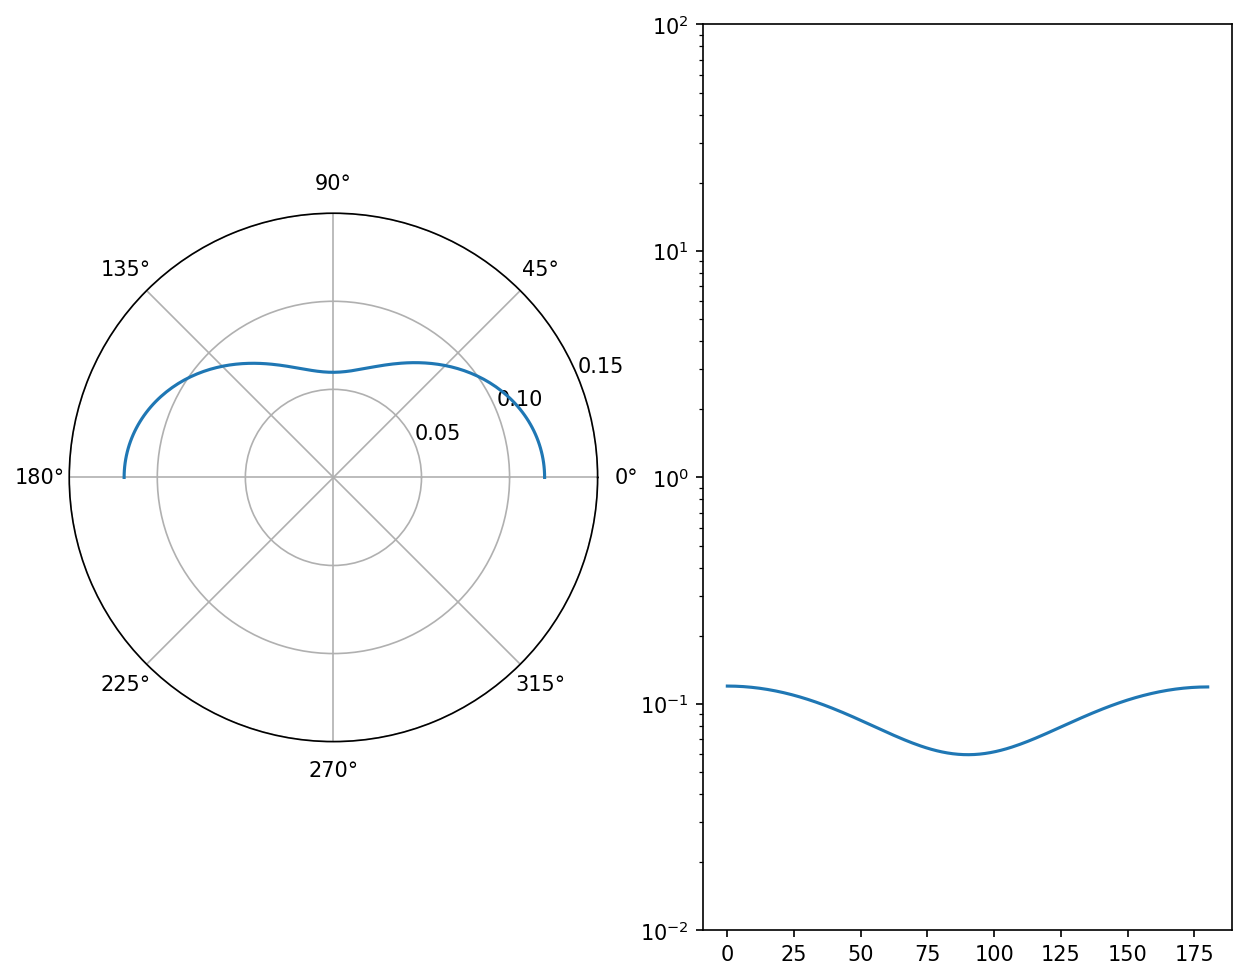

In [16]:
m = 1.33
x = 0.1
theta = np.linspace(0,180,180)
mu = np.cos(theta/180*np.pi)
scat = miepython.i_unpolarized(m,x,mu)

fig, (ax, ax1) = plt.subplots(1,2, figsize=(10,8), dpi=150)
ax = plt.subplot(121, projection='polar')
ax.plot(theta/180*np.pi,scat)
_ = ax.set_rticks([0.05, 0.1,0.15])

ax1.plot(theta, scat)
ax1.set_yscale('log')
ax1.set_ylim(0.01, 100)

Text(0.5, 0, '$\\Theta \\ (Deg.)$')

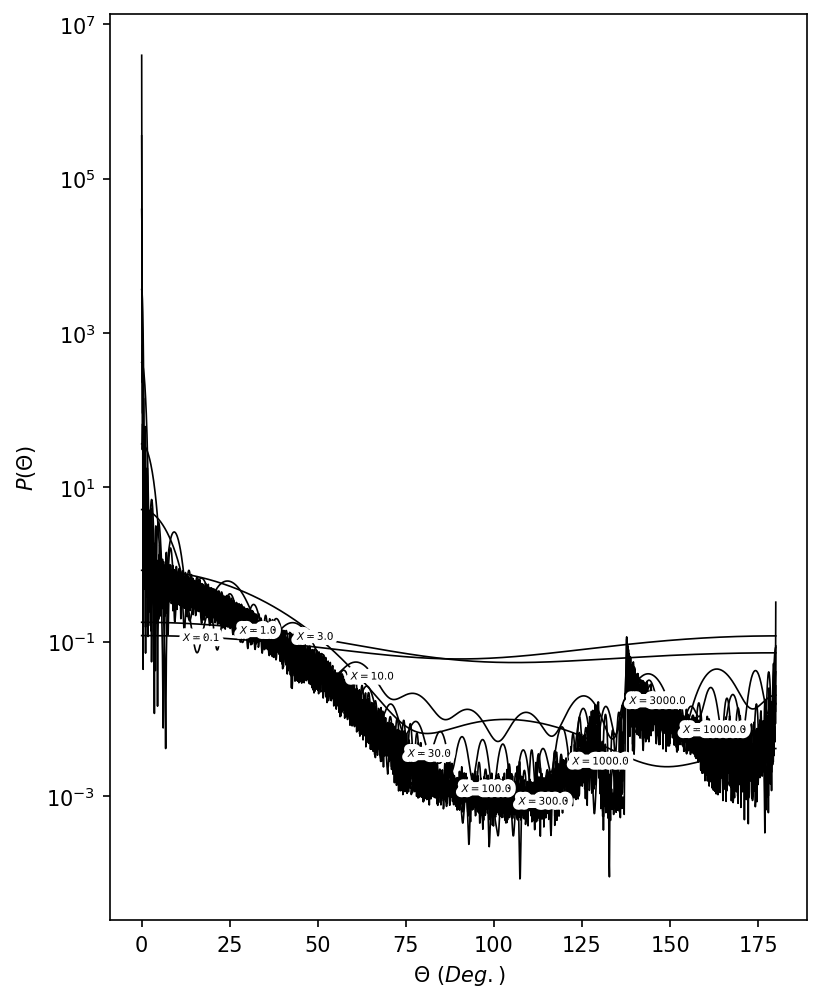

In [17]:
m = 1.33
x = [0.1, 1., 3, 10, 30, 100, 300, 1000, 3000, 10000]
theta = np.linspace(0, 180, 1800)
mu = np.cos(theta / 180 *  np.pi)
phase = []
for i in x:
    phase.append(miepython.i_unpolarized(m,i,mu))

fig, ax1 = plt.subplots(figsize=(6,8), dpi=150)
for idx, j in enumerate(phase):
    ax1.plot(theta, j, label=f'$X={x[idx]:.1f}$', c='k', lw=0.8)
ax1.set_yscale('log')
# ax1.set_ylim(0.001, 1e9)
_ = labelLines(fig.gca().get_lines(), color='k', fontsize=5
               , align=False)
ax1.set_ylabel(r'$P(\Theta)$')
ax1.set_xlabel(r'$\Theta \ (Deg.)$')

In [18]:
m = 1.33
x = [0.1, 1., 3, 10, 30, 100, 300, 1000, 3000, 10000]
offset = [0.02, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e7, 1e9]
theta = np.linspace(0, 180, 1800)
mu = np.cos(theta / 180 *  np.pi)
phase = []

Text(0.5, 0, '$\\Theta \\ (Deg.)$')

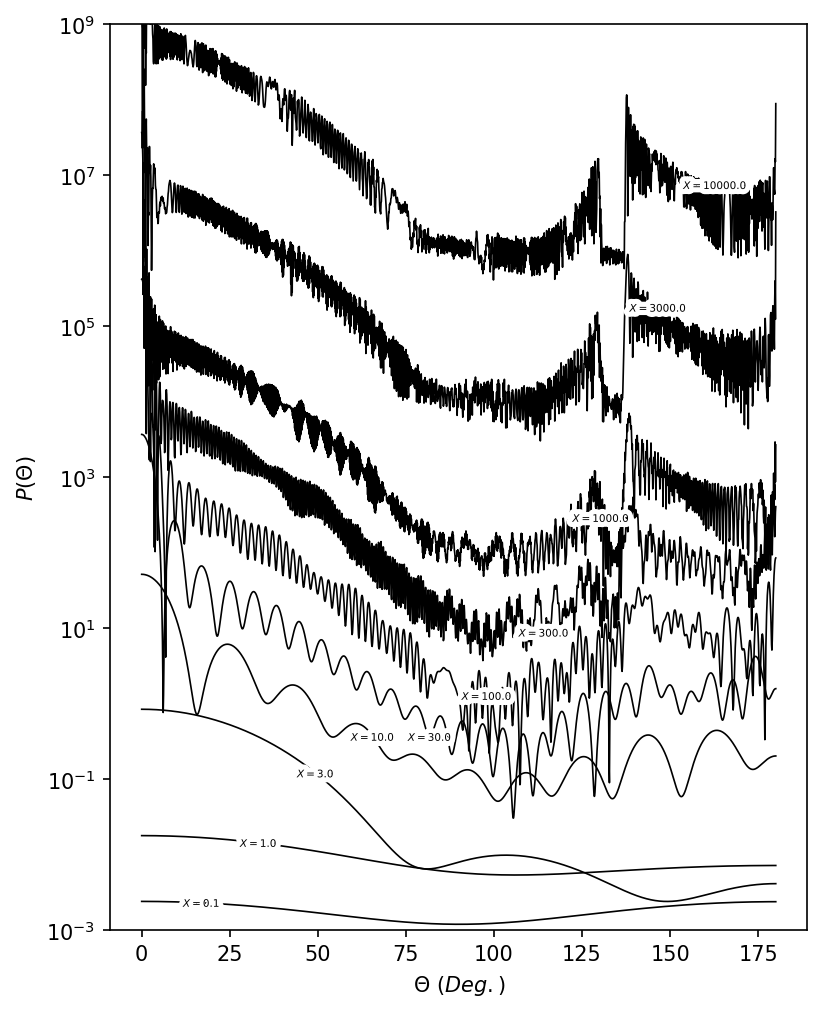

In [19]:

for i in x:
    phase.append(miepython.i_unpolarized(m,i,mu))

fig, ax1 = plt.subplots(figsize=(6,8), dpi=150)
for idx, j in enumerate(phase):
    ax1.plot(theta, j * offset[idx], label=f'$X={x[idx]:.1f}$', c='k', lw=0.8)
ax1.set_yscale('log')
ax1.set_ylim(0.001, 1e9)
_ = labelLines(fig.gca().get_lines(), color='k', fontsize=5
               , align=False)
ax1.set_ylabel(r'$P(\Theta)$')
ax1.set_xlabel(r'$\Theta \ (Deg.)$')

In [26]:
m = [refractive.m_w_0C[tmatrix_aux.wl_Ku], refractive.m_w_0C[tmatrix_aux.wl_Ka]]
d = np.arange(0.5, 3, 0.5)
x_ku = size_parm(d, "Ku")
x_ka = size_parm(d, "Ka")

In [27]:
phase_ku = []
phase_ka = []
for i in range(len(x_ku)):
    phase_ku.append(miepython.i_unpolarized(m[0], x_ku[i], mu))
    phase_ka.append(miepython.i_unpolarized(m[1], x_ka[i], mu))

In [41]:
phase_ka

[array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([0.34970846, 0.34970781, 0.34970584, ..., 0.71706948, 0.7170721 ,
        0.71707297])]

In [36]:
p_ku = phase_dask(d, wl="Ku", temp=0, m=None, _dask=False)
p_ku

array([[1.52829877e-06, 1.52806562e-06, 1.52736647e-06, 1.52620215e-06,
        1.52457408e-06, 1.52248423e-06, 1.51993512e-06, 1.51692986e-06,
        1.51347206e-06, 1.50956593e-06, 1.50521619e-06, 1.50042810e-06,
        1.49520747e-06, 1.48956060e-06, 1.48349435e-06, 1.47701605e-06,
        1.47013353e-06, 1.46285514e-06, 1.45518968e-06, 1.44714643e-06,
        1.43873511e-06, 1.42996592e-06, 1.42084944e-06, 1.41139673e-06,
        1.40161920e-06, 1.39152869e-06, 1.38113740e-06, 1.37045789e-06,
        1.35950308e-06, 1.34828621e-06, 1.33682085e-06, 1.32512084e-06,
        1.31320034e-06, 1.30107374e-06, 1.28875569e-06, 1.27626108e-06,
        1.26360500e-06, 1.25080273e-06, 1.23786972e-06, 1.22482159e-06,
        1.21167409e-06, 1.19844308e-06, 1.18514452e-06, 1.17179445e-06,
        1.15840898e-06, 1.14500423e-06, 1.13159637e-06, 1.11820155e-06,
        1.10483591e-06, 1.09151553e-06, 1.07825647e-06, 1.06507466e-06,
        1.05198598e-06, 1.03900617e-06, 1.02615081e-06, 1.013435

In [32]:
p_ku.shape

(5, 180)

(1e-06, 1)

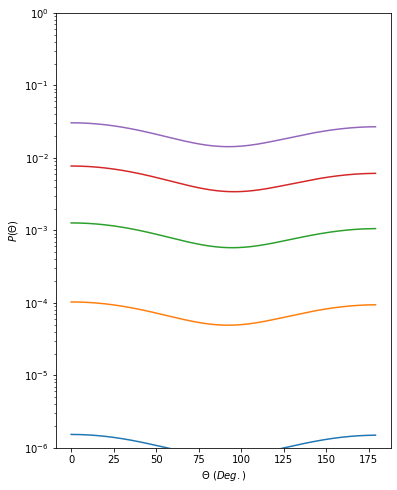

In [42]:
fig, ax1 = plt.subplots(figsize=(6,8))
for j in range(p_ku.shape[0]):
    ax1.plot(np.arange(0, 180, 1), p_ku[j])# label=f'$X={x[idx]:.1f}$', c='k', lw=0.8)
ax1.set_yscale('log')
ax1.set_ylim(0.001, 1e-1)
_ = labelLines(fig.gca().get_lines(), color='k', fontsize=5
               , align=False)
ax1.set_ylabel(r'$P(\Theta)$')
ax1.set_xlabel(r'$\Theta \ (Deg.)$')
ax1.set_ylim(0.000001,1)